In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import normflows as nf
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
from fab import FABModel, HamiltonianMonteCarlo, Metropolis
from fab.utils.logging import ListLogger
from fab.utils.plotting import plot_history, plot_contours, plot_marginal_pair
from fab.target_distributions.gmm import GMM
from fab.utils.prioritised_replay_buffer import SimpleBuffer
from torch.autograd import grad
from fab.utils.plotting import plot_contours, plot_marginal_pair
from experiments.make_flow import make_wrapped_normflow_realnvp
import models.ddpm
import models.mlp
import pdb
from tqdm import tqdm
from models.ddpm import GaussianDiffusion, TMLP
from models.mlp import MyMLP, SpectralNormMLP

import torch
import torchsde

from functorch import vmap

from torchdiffeq import odeint

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Target Distribution

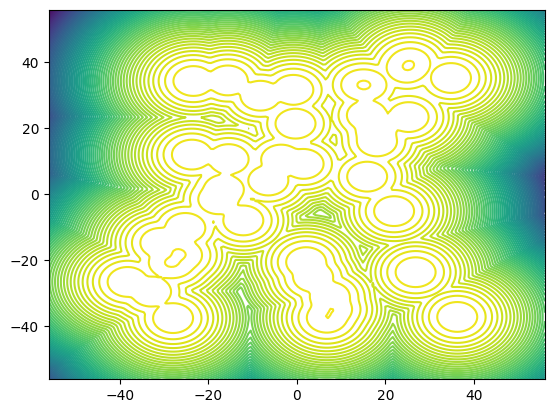

In [4]:
dim = 2
n_mixes = 40
loc_scaling = 40.0  # scale of the problem (changes how far apart the modes of each Guassian component will be)
log_var_scaling = 1.0 # variance of each Gaussian
seed = 0


if device == "cpu":
    use_gpu = False
else:
    use_gpu = True
torch.manual_seed(0)  # seed of 0 for GMM problem
target = GMM(dim=dim, n_mixes=n_mixes,
              loc_scaling=loc_scaling, log_var_scaling=log_var_scaling,
              use_gpu=use_gpu, true_expectation_estimation_n_samples=int(1e5))
# plot target
target.to("cpu")
fig, ax = plt.subplots()
plotting_bounds = (-loc_scaling * 1.4, loc_scaling * 1.4)
plot_contours(target.log_prob, bounds=plotting_bounds, n_contour_levels=80, ax=ax, grid_width_n_points=200)
target.to(device)

### Helper Functions

In [5]:
def plot_dataset(samples, gen_samples=None):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    target.to("cpu")
    plot_contours(target.log_prob, bounds=plotting_bounds, ax=axs[0], n_contour_levels=50, grid_width_n_points=200)

   
    # plot dataset samples
    plot_marginal_pair(samples, ax=axs[0], bounds=plotting_bounds)
    axs[0].set_title("Buffer")

    if gen_samples is not None:
        plot_contours(target.log_prob, bounds=plotting_bounds, ax=axs[1], n_contour_levels=50, grid_width_n_points=200)
        # plot generated samples
        plot_marginal_pair(gen_samples, ax=axs[1], bounds=plotting_bounds)
        axs[1].set_title("Generated samples")

    else:
        #delete subplot
        fig.delaxes(axs[1])
        
    target.to(device)
    plt.show()
    return [fig]

In [6]:
def normalize(x):
    '''
        normalizes to [-1, 1]
    '''
    mins = -50 #torch.min(x, dim=0)[0]
    maxs = 50 #torch.max(x, dim=0)[0]
    ## [ 0, 1 ]
    x = (x - mins) / (maxs - mins + 1e-5)
    ## [ -1, 1 ]
    x = x * 2 - 1
    
    return x, mins, maxs

def unnormalize(x, mins, maxs):
    '''
        x : [ -1, 1 ]
    '''
    # assert x.max() <= 1 and x.min() >= -1, f'x range: ({x.min():.4f}, {x.max():.4f})'
    #x = x * std + mean
    x = (x + 1) / 2
    return x * (maxs - mins) + mins

## Function Definitions

### Estimated Reward Functions

In [7]:
# calculate the log expectation of the reward
def log_E_R(_x, _t, beta, num_mc_samples, global_mins=-50, global_maxs=50, var_exploding=True):
    h_t = beta * _t.repeat_interleave(num_mc_samples).unsqueeze(1)
    repeated_x = _x.unsqueeze(0).repeat_interleave(num_mc_samples, dim=0)
    repeated_t = _t.unsqueeze(0).repeat_interleave(num_mc_samples, dim=0)
    h_t  = beta * repeated_t
    h_t = h_t.unsqueeze(1)
    if var_exploding:
        # variance exploding
        samples = repeated_x + torch.randn(repeated_x.shape).to(device) * (h_t ** 0.5)
        log_rewards = target.log_prob(unnormalize(samples, global_mins, global_maxs))
        log_expectation_R = torch.logsumexp(log_rewards, dim=-1) - np.log(num_mc_samples)
    else:
        # variance preserving
        samples = repeated_x/torch.sqrt(1 - repeated_t.unsqueeze(1)) + torch.randn(repeated_x.shape).to(device) * (h_t ** 0.5)
        log_rewards = target.log_prob(unnormalize(samples, global_mins, global_maxs))
        log_expectation_R = torch.log(1 / (1 - _t)) + torch.logsumexp(log_rewards, dim=-1) - np.log(num_mc_samples)
    return log_expectation_R

In [8]:
def estimated_Rt(x, t, beta, num_mc_samples=100, var_exploding=True):
    t = t * torch.ones(x.shape[0]).to(device)
    return torch.vmap(log_E_R, 
                      randomness='different', in_dims=(0,0,None,None))(x, t, beta, num_mc_samples, var_exploding=var_exploding)

In [9]:
def estimate_grad_Rt(x, t, beta, num_mc_samples=100, var_exploding=True, richardson=False):
    t = t * torch.ones(x.shape[0]).to(device)
    est_scores_n = torch.vmap(torch.func.grad(log_E_R), 
                            in_dims=(0,0,None,None), randomness='different')(x, t, beta, num_mc_samples, 
                                                                                  var_exploding=var_exploding)
    if richardson:
        est_scores_n_div2 = torch.vmap(torch.func.grad(log_E_R), 
                                   in_dims=(0,0,None,None), randomness='different')(x, t, beta, num_mc_samples//2, 
                                                                                         var_exploding=var_exploding)
        return (2*est_scores_n - est_scores_n_div2)
    else:
        return est_scores_n

### True Reward Functions

In [10]:
def true_Rt(x, t, beta, global_mins=-50, global_maxs=50, var_exploding=True):
    h_t = beta * t
    target.convolve(h_t * (global_maxs **2), t, var_exploding=var_exploding)
    energy = target.log_prob(unnormalize(x, global_mins, global_maxs))
    target.reset()
    return energy

In [11]:
def true_grad_Rt(x, t, beta, var_exploding=True):
    samples_energy = true_Rt(x, t, beta, var_exploding=var_exploding)
    true_scores = torch.autograd.grad(samples_energy.sum(), x, retain_graph=True)[0].detach()
    return true_scores

# Testing

In [12]:
# sample uniformly from the grid
num_grid = 100
X = torch.linspace(-1, 1, num_grid)
Y = torch.linspace(-1, 1, num_grid)

# create a grid of (x,y) coordinates
x = torch.meshgrid(X, Y)

# make x into tensor
x = torch.stack(x, dim=2).reshape(-1, 2)
x = x.to(device)
x.requires_grad = True

/home/mila/t/tara.akhoundsadegh/.conda/envs/actinfenv/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


## SDE Tests

### Dataset

In [13]:
# hyper-parameters

# Flow
n_flow_layers = 15
layer_nodes_per_dim = 40
lr = 1e-4
max_gradient_norm = 100.0
batch_size = 128
n_iterations = 4000
n_eval = 10
eval_batch_size = batch_size * 10
n_plots = 10 # number of plots shows throughout tranining
use_64_bit = True
alpha = 2.0
num_samples = 10000

flow = make_wrapped_normflow_realnvp(dim, n_flow_layers=n_flow_layers, 
                                 layer_nodes_per_dim=layer_nodes_per_dim,
                                act_norm = False)

/home/mila/t/tara.akhoundsadegh/.conda/envs/actinfenv/lib/python3.10/site-packages/torch/_tensor.py:677: UserWarning: torch.lu is deprecated in favor of torch.linalg.lu_factor / torch.linalg.lu_factor_ex and will be removed in a future PyTorch release.
LU, pivots = torch.lu(A, compute_pivots)
should be replaced with
LU, pivots = torch.linalg.lu_factor(A, compute_pivots)
and
LU, pivots, info = torch.lu(A, compute_pivots, get_infos=True)
should be replaced with
LU, pivots, info = torch.linalg.lu_factor_ex(A, compute_pivots) (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1991.)
  LU, pivots, infos = torch._lu_with_info(


In [14]:
# normalize the dataset
init_num_samples = 2048
unnorm_true_samples = target.sample(torch.tensor(init_num_samples).unsqueeze(0)).to(device).detach()
unnorm_init_samples = flow.sample((init_num_samples,)).to(device).detach()
init_energy = target.log_prob(unnorm_init_samples).detach()
init_samples, global_mins_init, global_maxs_init = normalize(unnorm_init_samples)

global_mins_init = -50
global_maxs_init = 50

init_dataset = TensorDataset(init_samples, init_energy)
init_loader = DataLoader(init_dataset, batch_size = 512, shuffle=True) 

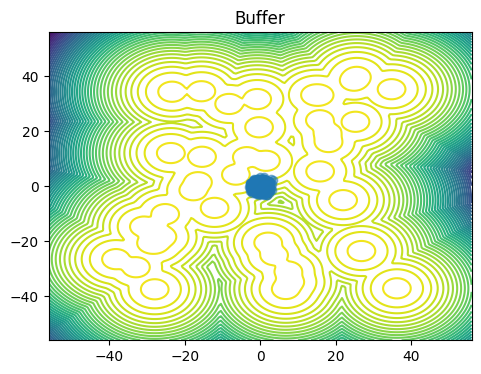

In [15]:
plot_dataset(unnorm_init_samples) # visualise the initial samples
plt.show()

### VE SDE

In [16]:
class VEReverseSDE(torch.nn.Module):
    noise_type = 'diagonal'
    sde_type = 'ito'
    
    def __init__(self, score, beta):
        super().__init__()
        self.score = score
        self.beta = beta
    
    def f(self, t, x):
        with torch.enable_grad():
            x.requires_grad = True
            score = self.score(x, 1-t, self.beta)
        return self.g(t, x)**2 * score 
    
    def g(self, t, x):
        return torch.full_like(x, self.beta ** 0.5)

In [17]:
def generate_samples(ve_reverse_sde, x_init):
    t = torch.linspace(0.001, 1.0, 500)
    with torch.no_grad():
        samples = torchsde.sdeint(ve_reverse_sde, x_init, t)
    return samples

In [18]:
num_samples = 400
beta = 0.2

target.convolve(torch.tensor(1000, device=torch.device('cpu')), 1)
x1_samples = target.sample((num_samples,))
target.reset()
x1_samples_normalized = normalize(x1_samples)[0]

In [19]:
# ve_reverse_sde = VEReverseSDE(true_grad_Rt, beta)
ve_reverse_sde = VEReverseSDE(estimate_grad_Rt, beta)
samples = generate_samples(ve_reverse_sde, x1_samples_normalized)

KeyboardInterrupt: 

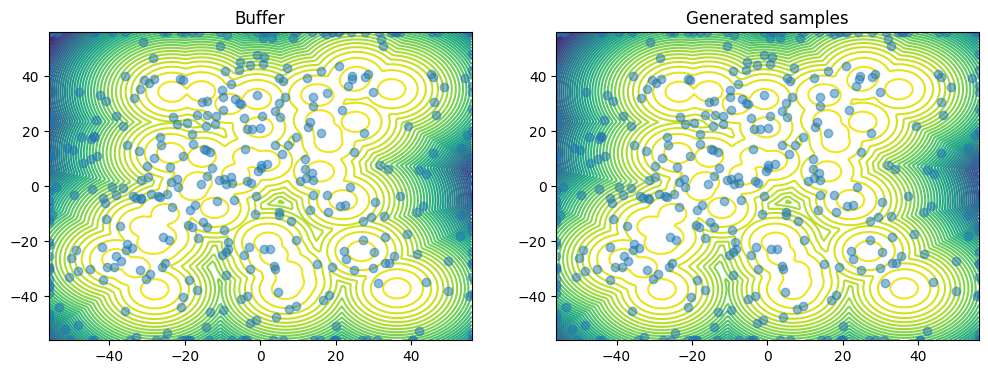

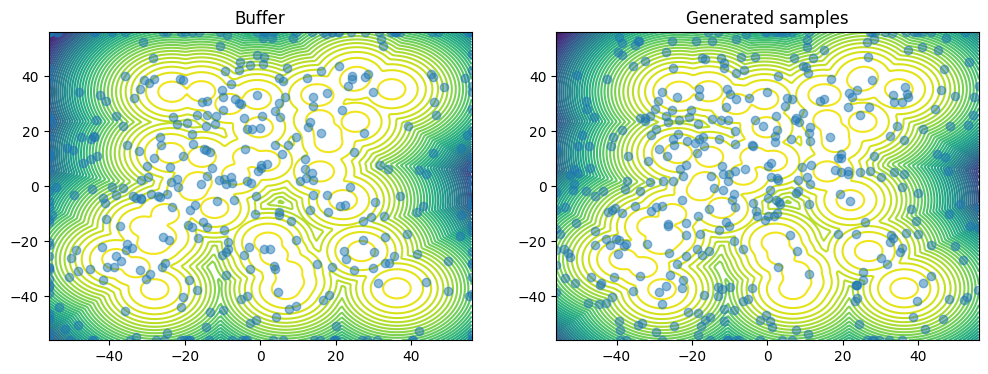

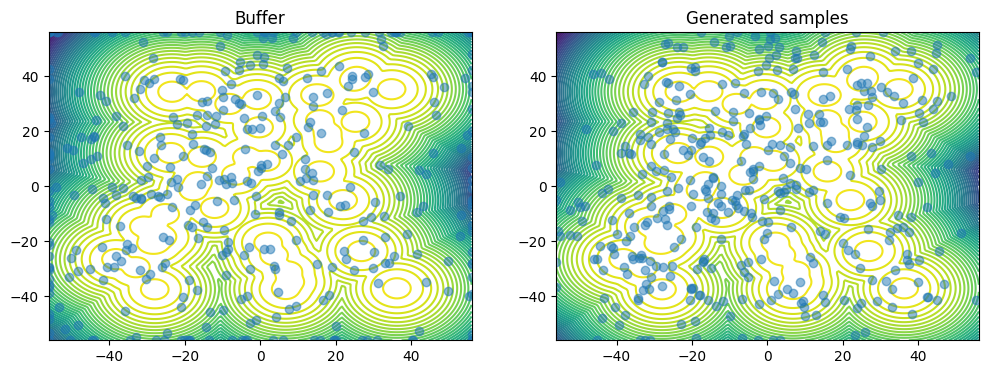

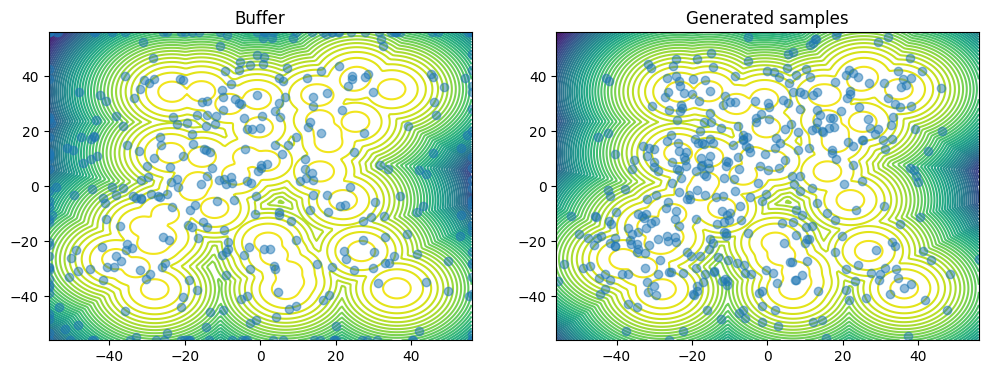

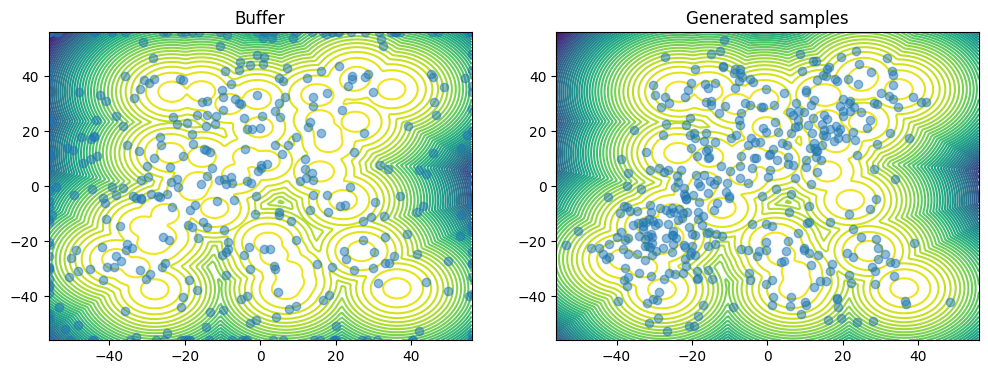

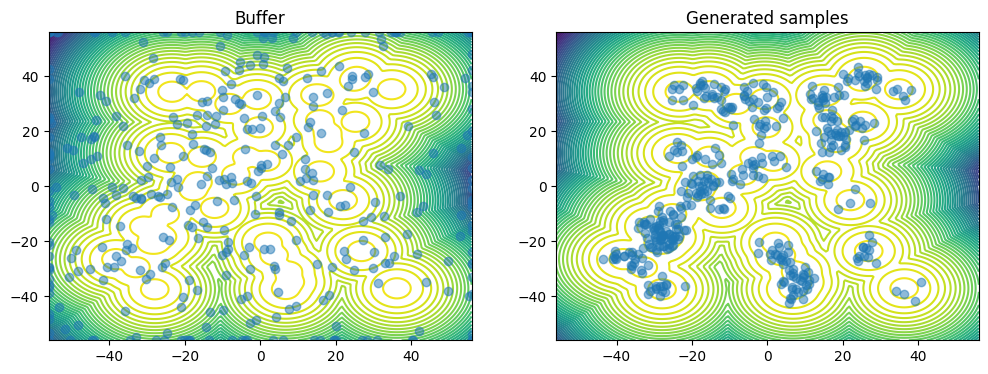

In [ ]:
for i in range(0, 500, 99):
    plot_dataset(x1_samples, unnormalize(samples[i], global_mins_init, global_maxs_init))

### VP SDE

In [ ]:
class VEReverseSDE(torch.nn.Module):
    noise_type = 'diagonal'
    sde_type = 'ito'
    
    def __init__(self, score, beta):
        super().__init__()
        self.score = score
        self.beta = beta
    
    def f(self, t, x):
        with torch.enable_grad():
            x.requires_grad = True
            score = self.score(x, 1-t, self.beta)
        return self.g(t, x)**2 * score 
    
    def g(self, t, x):
        return torch.full_like(x, self.beta ** 0.5)